In [19]:
from tensorflow.keras.models import model_from_json
import os
import numpy as np
from PIL import Image
from IPython.display import clear_output
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import pandas as pd
import copy
import pickle
from scipy.cluster.hierarchy import dendrogram, linkage


%run ../utils/object_detection_utils.ipynb
%run ../utils/image_utils.ipynb
%run ../utils/data_utils.ipynb
%run ./variables.ipynb
%run ./utils.ipynb

id_map_path = os.path.join(SAVED_MODELS_ROOT, 'model_id_map.csv')
id_map = get_selected_taxons(id_map_path)
inv_id_map = get_selected_taxons(id_map_path, inv=True)

# Getting ytest and ypred

In [ ]:
X_test, y_test = [], []
images_paths=read_csv(os.path.join(SAVED_MODELS_ROOT, "test_list.csv"))
for image_path in images_paths:
    X_test.append(image_path)
    y_test.append(id_map[image_path.split("/")[-2]])
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
json_file = open(os.path.join(SAVED_MODELS_ROOT, "model.json"), 'r')
print(json_file)
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights(os.path.join(SAVED_MODELS_ROOT, "weights.hdf5"))

In [ ]:
thumbails_batch = []
for file in X_test:
    sample = load_image(file, expand=True)
    thumbails_batch.append(sample)
    #display(Image.fromarray(sample))
thumbails_batch = np.array(thumbails_batch).astype('float32')/255
outs = model.predict(thumbails_batch, use_multiprocessing=True)
y_pred = np.array([np.argmax(out) for out in outs])

In [ ]:
pickle.dump(y_test, open( "ytest.p", "wb" ))
pickle.dump(y_pred, open( "ypred.p", "wb" ))

# Creating artifical taxonomy

## Computing similarity

In [2]:
y_test = pickle.load( open( "ytest.p", "rb" ) )
y_pred = pickle.load( open( "ypred.p", "rb" ) )
tmp=np.abs(y_test-y_pred)
print("Accuracy:", len(np.where(tmp==0)[0])/len(y_test))

Accuracy: 0.8565656565656565


In [17]:
C = tf.math.confusion_matrix(y_test, y_pred).numpy()
C_norm = C/C.astype(np.float).sum(axis=1)
C_over = (C_norm+np.transpose(C_norm))/2
np.fill_diagonal(C_over, 1)
S = 1-C_over

## Clustering

In [ ]:
#classes = [[c] for c in S]
Z = linkage(S, 'ward')

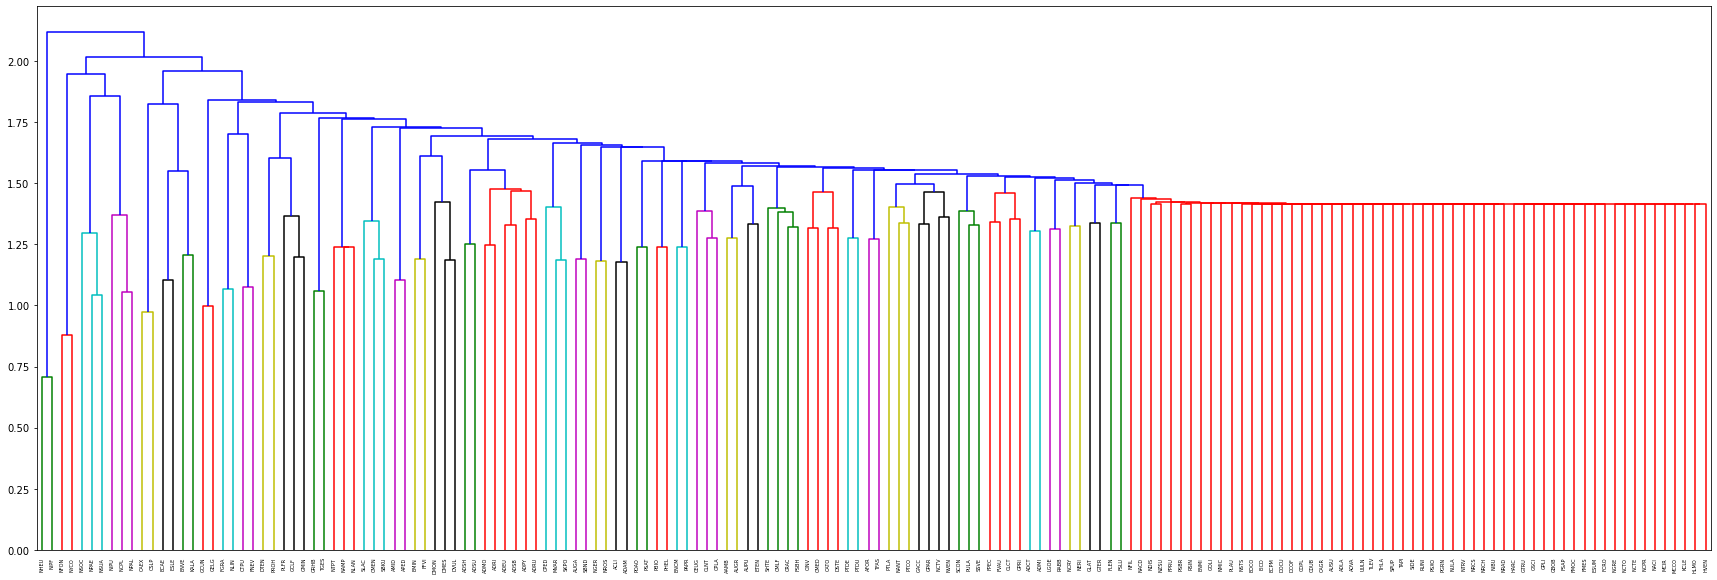

In [46]:
fig = plt.figure(figsize=(30, 10), frameon = True)
dn = dendrogram(Z, labels=list(id_map.keys()))
plt.savefig('dendogram.png', dpi = 400, bbox_inches='tight', pad_inches=0)

# Old

In [ ]:
conf_mat_perc = conf_mat.copy().astype("float32")
for i in range(len(conf_mat_perc)):
    conf_mat_perc[i] = conf_mat_perc[i]/np.sum(conf_mat_perc[i])

In [ ]:
labels = list(id_map.keys())

In [ ]:
sn.set()
df_cm = pd.DataFrame(conf_mat_perc, index = [i for i in labels],
                  columns = [i for i in labels])
fig = plt.figure(figsize = (100,70))
sn.heatmap(df_cm,
           annot=True)
           #norm=LogNorm())
           #cbar_kws={'format': FuncFormatter(fmt)})
fig.savefig('foo.png', bbox_inches='tight')
plt.close(fig)